# TDT4173 Machine Learning Report

### Kaggle username: Group 43 

### Blackboard group: 043

#### Team members: Ola Sæther (544629), Olav Finne Præsteng Larsen (542616), Simeon Christoffersen (543897)

#### The report inlcudes the following sections:
- Exploratory data analysis (EDA)
  - Importing datasets 
  - Understand the data and how it was generated
  - Merging observed and estimated datasets
  - Merging datarows within the same date and hour
  - Domain knowledge
  - Explore individual features
  - Cleaning dataset
  - Explore pairs and groups of features
- Feature engineering
  - Time feature engineering 
  - Binary feature indicating difference between estimated and observed
  - Lag feature
  - Summer Weighting
  - Wind direction
  - Combining diffuse rad and direct rad
  - One hot encoding precip type and dew or rime
- Models and trainings
  - Training and reproducibility
  - Estimated data
  - Categorical features
  - LightGBM (with feature importance)
  - Ensemble XGBoost and RandomForest
  - AutoGluon
  - H2O
  - CatBoost with optuna
    - Results from optuna
    - Catboost with optuna using Cross Validation
    - CatBoost with optuna using single train/validation split
  - CatBoost (Short Notebook 1)
  - CatBoost and AutoGluon (Short Notebook 2)
    - CatBoost
    - AutoGluon
- Model interpretation
  - PDP


## Explotary Data Analysis



### Importing datasets
We started our EDA with importing the given datasets by using pandas

In [69]:
import pandas as pd
import numpy as np

In [70]:
def get_X_train_estimated_path(dataset):
    return f'../data/{dataset}/X_train_estimated.parquet'

def get_X_train_observed_path(dataset):
    return f'../data/{dataset}/X_train_observed.parquet'

def get_target_path(dataset):
    return f"../data/{dataset}/train_targets.parquet"

def get_test_estimated_path(dataset):
    return f'../data/{dataset}/X_test_estimated.parquet'

### Understand the data and how it was generated
In our datasets there are weather records for every quarter. However the task we are given is to predict pv generation per hour. In order to solve our given task we therefore needed to somehow add together the different weather features to reduce the granularity of our data. We noticed that parts of the data was observed weather measurements, while others were based on forecasts. It seemed that the estimated data was generated the day before, illustrated by looking at the timestamp in date_calc and date_forecast below (this example is based on dataset A).  

In [71]:
X_train_estimated_a = pd.read_parquet(get_X_train_estimated_path('A'))
X_train_estimated_a.head()

date_calc       date_forecast  absolute_humidity_2m:gm3  \
0 2022-10-27 07:00:18 2022-10-28 22:00:00                       8.4   
1 2022-10-27 07:00:18 2022-10-28 22:15:00                       8.4   
2 2022-10-27 07:00:18 2022-10-28 22:30:00                       8.3   
3 2022-10-27 07:00:18 2022-10-28 22:45:00                       8.3   
4 2022-10-27 07:00:18 2022-10-28 23:00:00                       8.2   

   air_density_2m:kgm3  ceiling_height_agl:m  clear_sky_energy_1h:J  \
0                1.233           1425.099976                    0.0   
1                1.233           2085.899902                    0.0   
2                1.233           2746.600098                    0.0   
3                1.233           3407.399902                    0.0   
4                1.233           4068.199951                    0.0   

   clear_sky_rad:W  cloud_base_agl:m  dew_or_rime:idx  dew_point_2m:K  ...  \
0              0.0       1211.699951              1.0      281.399994  ...   
1              0.0       1560.500000              1.0      281.299988  ...   
2              0.0       1909.400024              1.0      281.200012  ...   
3              0.0       2258.199951              1.0      281.200012  ...   
4              0.0       2607.000000              1.0      281.100006  ...   

   sun_azimuth:d  sun_elevation:d  super_cooled_liquid_water:kgm2  \
0     340.799011       -38.466999                             0.0   
1     345.451996       -38.955002                             0.0   
2     350.153015       -39.310001                             0.0   
3     354.886993       -39.528999                             0.0   
4     359.638000       -39.609001                             0.0   

   t_1000hPa:K  total_cloud_cover:p  visibility:m  wind_speed_10m:ms  \
0   284.700012                100.0  29429.699219                0.8   
1   284.700012                100.0  23604.099609                0.7   
2   284.700012                100.0  17799.800781                0.7   
3   284.600006                100.0  12016.500000                0.6   
4   284.600006                100.0   6254.399902                0.6   

   wind_speed_u_10m:ms  wind_speed_v_10m:ms  wind_speed_w_1000hPa:ms  
0                 -0.4                  0.7                     -0.0  
1                 -0.4                  0.7                     -0.0  
2                 -0.3                  0.6                     -0.0  
3                 -0.2                  0.6                     -0.0  
4                 -0.1                  0.6                     -0.0  

[5 rows x 47 columns]

### Merging observed and estimated datasets together with target values
To be able to merge the observed and estimated data with the target values, we had to create som new temporary features like date, hour and minute. These features were dropped after the merging.

In [72]:
def combine_data(dataset):
    X_train_estimated = pd.read_parquet(get_X_train_estimated_path(dataset))
    X_train_observed = pd.read_parquet(get_X_train_observed_path(dataset))
    target = pd.read_parquet(get_target_path(dataset))

    X_train_estimated['validation'] = True
    X_train_observed['validation'] = False

    df = pd.concat([X_train_observed, X_train_estimated], axis=0)
    df.rename(columns={"date_forecast":"datetime"}, inplace=True)
    df['date'] = df['datetime'].dt.date
    df['hour'] = df['datetime'].dt.hour

    target['date'] = target['time'].dt.date
    target['hour'] = target['time'].dt.hour
    df = df.merge(target, on=['date','hour'], how='inner')

    df = df.dropna(subset=['pv_measurement'])
    df.set_index('datetime', inplace=True)
    df.drop(columns=['date_calc'], inplace=True)
    df.drop(columns=['date', 'hour','time'], inplace=True)
    df.columns = [col.replace(':', '_') for col in df.columns]
    
    return df

In [73]:
X_test_A = pd.read_parquet(get_test_estimated_path('A'))
X_test_A = X_test_A.rename(columns={'date_forecast': 'datetime'})
X_test_A = X_test_A.drop(columns=['date_calc'])
X_test_A.set_index("datetime", inplace=True)


X_test_B = pd.read_parquet(get_test_estimated_path('B'))
X_test_B = X_test_B.rename(columns={'date_forecast': 'datetime'})
X_test_B = X_test_B.drop(columns=['date_calc'])
X_test_B.set_index("datetime", inplace=True)

X_test_C = pd.read_parquet(get_test_estimated_path('C'))
X_test_C = X_test_C.rename(columns={'date_forecast': 'datetime'})
X_test_C = X_test_C.drop(columns=['date_calc'])
X_test_C.set_index("datetime", inplace=True)

X_train_a = combine_data('A')
X_train_b = combine_data('B')
X_train_c = combine_data('C')


### Merging datarows within the same date and hour
Before starting our data analysis, we decided to consolidate data rows within the same date and hour. This was because our goal was to predict the PV measurements for each hour, rather than every quarter. For most columns, we calculated the mean of the values during the merging process. However, for certain features, we realized that using the mean could lead to misinformation. Specifically, we treated index features (ending with 'idx') as categorical features. For these, we applied a 'most_frequent(df)' method to identify the most frequent value within each hour. Features measured like watts (ending with 'W') and some others were handled differently, as we summed their values instead. Lastly, for some features, we simply used the last value within the hour for aggregation. This was because these features captures weather measurements every entire hour, in contrast to direct rad which is for every quarter.

We also removed rows in the datasets where the daily pv measurements were 0.

In [74]:
def most_frequent(x):
    """
    Method used to combine rows from quarters into hours for categorical features. Takes the feature that is most present for that hour and sets is as the value for the hour
    :param x: 4 values, 1 for each quarter of the hour
    :return: The value that should be set for the hour
    """
    counts = x.value_counts()
    if counts.empty:
        return None
    return counts.index[0] if all(counts == counts.iloc[0]) else counts.idxmax()

categorical_features = ['precip_type_5min_idx', 'dew_or_rime_idx', 'is_day_idx', 'is_in_shadow_idx']
sum_cols = [ 'clear_sky_rad_W','direct_rad_W', 'diffuse_rad_W', 'precip_5min_mm', 'rain_water_kgm2', 'snow_water_kgm2', 'snow_melt_10min_mm', 'super_cooled_liquid_water_kgm2']
last_cols = ['clear_sky_energy_1h_J','direct_rad_1h_J','fresh_snow_1h_cm', 'diffuse_rad_1h_J','fresh_snow_6h_cm', 'fresh_snow_3h_cm', 'fresh_snow_12h_cm', 'fresh_snow_24h_cm']

In [75]:
def clean_train(df):
    """
    Method for cleaning the training data. Replaces : with _ in the colum names. Removes any days that have a daily sum of pv_measurement of 0, since no power was generated that day, which the group recognizes as bad data

    :param df: Dataset
    :return: Cleaned Dataset
    """
    df.columns = [col.replace(':', '_') for col in df.columns]

    df['DailySum'] = df.groupby(df.index.date)['pv_measurement'].transform('sum')
    df = df[df['DailySum'] > 0]
    df.drop('DailySum', axis=1, inplace=True)
    return df

In [76]:
def merging_datarows_into_hours(df):
    mean_columns = [col for col in df.columns if col not in categorical_features and col not in sum_cols and col not in last_cols]
    agg_dict = {col: 'mean' for col in mean_columns}
    agg_dict.update({col: most_frequent for col in categorical_features})
    agg_dict.update({col: 'sum' for col in sum_cols})
    agg_dict.update({col: 'last' for col in last_cols})

    df = df.resample('H').agg(agg_dict)
    df = df[df['pv_measurement'].notna()]
    return df

X_train_a = merging_datarows_into_hours(clean_train(X_train_a))
X_train_b = merging_datarows_into_hours(clean_train(X_train_b))
X_train_c = merging_datarows_into_hours(clean_train(X_train_c))


C:\Users\vizlab_stud\AppData\Local\Temp\ipykernel_28728\444949208.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('DailySum', axis=1, inplace=True)
C:\Users\vizlab_stud\AppData\Local\Temp\ipykernel_28728\444949208.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop('DailySum', axis=1, inplace=True)
C:\Users\vizlab_stud\AppData\Local\Temp\ipykernel_28728\444949208.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Domain knowledge
To learn more about our given domain we took to the internet to gain knowledge and understanding for solar forcasting. We found that direct radiation and timestamp had great impact on prediction performance. In addition, several researchers had found good use of historical PV measurments as lag features. Furthermore, the articles explain that snow negativley impacts the maximal pv measurment output.

Finally, we searched the articles for models that suit our given domain the best. Variations of gradient boosting models are presented as the best approach for fast implementation and good accuracy and this was therefore the approach we selected instead of relaying on heavier neural nets. 

Source: 
- https://medium.com/@akashprabhakar427/solar-power-forecasting-using-machine-learning-and-deep-learning-61d6292693de
- https://arxiv.org/ftp/arxiv/papers/2303/2303.07875.pdf
- https://en.wikipedia.org/wiki/Solar_power_forecasting
- https://www.e3s-conferences.org/articles/e3sconf/pdf/2021/85/e3sconf_icmed2021_01163.pdf 

### Exploring individual features
To explore the individual features, we plotted each of them by running this:

Training dataset A:


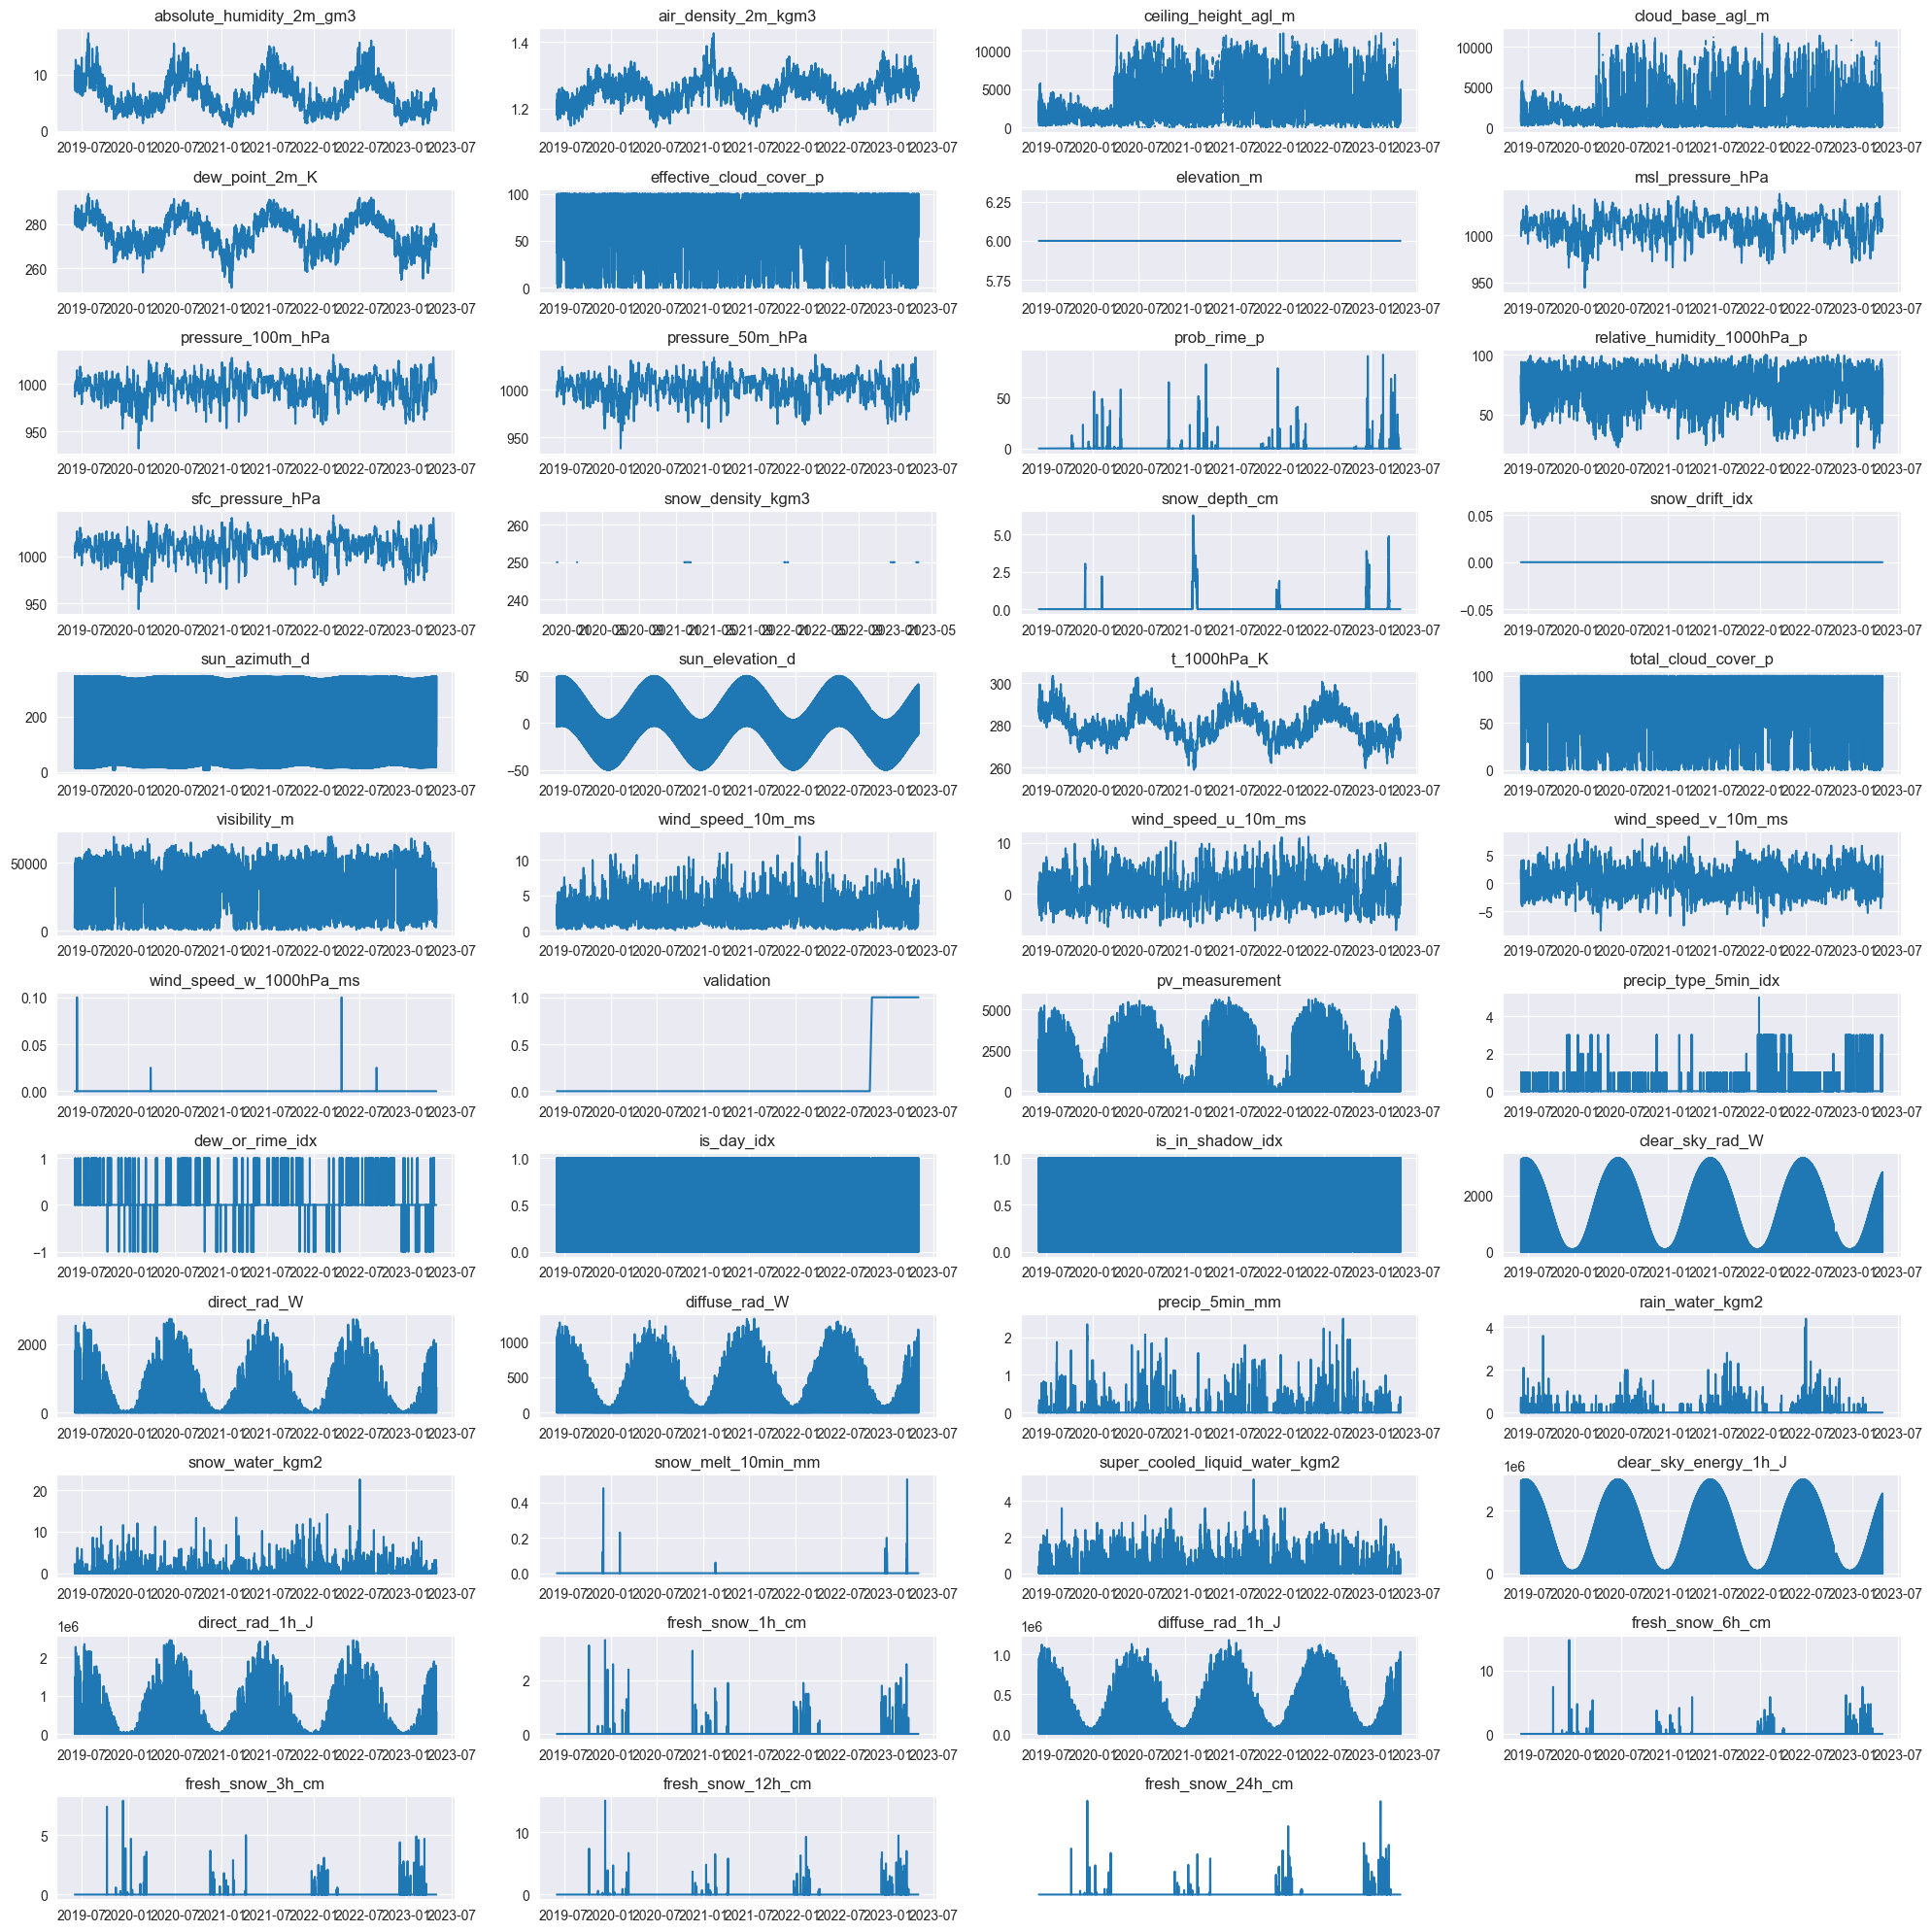

Training dataset B:


Training dataset C:


In [77]:
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

print("Training dataset A:")

fig, axes = plt.subplots(12, 4, figsize=(20, 20))  
axes = axes.flatten()  
for i in range(len(X_train_a.columns)):
    data = X_train_a[X_train_a.columns[i]]
    axes[i].plot(data)
    axes[i].set_title(X_train_a.columns[i])
for j in range(46, 48):
    axes[j].axis('off')
plt.tight_layout()
plt.show()


print("Training dataset B:")

fig, axes = plt.subplots(12, 4, figsize=(20, 20))  
axes = axes.flatten()  
for i in range(len(X_train_b.columns)):
    data = X_train_b[X_train_b.columns[i]]
    axes[i].plot(data)
    axes[i].set_title(X_train_b.columns[i])
for j in range(46, 48):
    axes[j].axis('off')
plt.tight_layout()
plt.show()

print("Training dataset C:")

fig, axes = plt.subplots(12, 4, figsize=(20, 20))  
axes = axes.flatten()  
for i in range(len(X_train_c.columns)):
    data = X_train_c[X_train_c.columns[i]]
    axes[i].plot(data)
    axes[i].set_title(X_train_c.columns[i])
for j in range(46, 48):
    axes[j].axis('off')
plt.tight_layout()
plt.show()




Interesting findings after investigation the plots:
- Dataset A has more or less continuous data, apart from the period between observed and estimated data. This period is approximately 1 week at the end of October 2022.
- Datasets B and C have more "holes" in their data, especially around the summer of 2022. 
- All three datasets have missing values in ceiling_height_agl_m, cloud_base_agl_m and snow_density_kgm3
- The features ceiling_height_agl_m and cloud_base_agl_m' have both some strange data in the beginning of the period in all three datasets. Their measurements are significantly lower in the first year than the remaining ones
- Elevation_m is constant in all three datasets
- Snow_drift_idx is constant in datset A and has one outliner in dataset B and C


NOTE: We enlarged the plots of individual features to facilitate a more detailed analysis of the data. For the reader's convenience, these plots have been arranged into a grid to enhance readability and comparison.


### Cleaning dataset
As we observed by plotting the different features in all three datasets, we found out that ceiling_height_agl_m, cloud_base_agl_m and snow_density_kgm3 all had missing values. But to be sure that we spotted all the features with missing values, we ran this code:


In [78]:
print("\nFeatures in X_train_a with missing values: \n" + str(X_train_a.columns[X_train_a.isnull().any()].tolist()))
print("\nFeatures in X_train_b with missing values: \n" + str(X_train_b.columns[X_train_b.isnull().any()].tolist()))
print("\nFeatures in X_train_c with missing values: \n" + str(X_train_c.columns[X_train_c.isnull().any()].tolist()))


Features in X_train_a with missing values: 
['ceiling_height_agl_m', 'cloud_base_agl_m', 'snow_density_kgm3']

Features in X_train_b with missing values: 
['ceiling_height_agl_m', 'cloud_base_agl_m', 'snow_density_kgm3']

Features in X_train_c with missing values: 
['ceiling_height_agl_m', 'cloud_base_agl_m', 'snow_density_kgm3']


By running this, we got confirmed that just these three features had missing values in all three datasets. For the snow density feature, we observed that it had only data in the winter months. Therefore, we chose to fill the missing values with 0. 

In [79]:
def fill_missing_values(df):
    df['snow_density_kgm3'] = df['snow_density_kgm3'].fillna(0)
    return df

For the ceiling height and cloud base, we tried using both mice and interpolation to fill in the missing values. Here is the code we used: 

In [80]:
import miceforest as mf

def interpolate_missing_values(df):
    df['ceiling_height_agl_m'].interpolate(method='linear', inplace=True)
    df['cloud_base_agl_m'].interpolate(method='linear', inplace=True)
    return df

def mice_missing_values(df):
    kds = mf.ImputationKernel(df, save_all_iterations=True, random_state=100)
    kds.mice(5)
    df_imputed = kds.complete_data()
    return df_imputed

Ultimately, we chose to exclude three features from our analysis. This decision stemmed from uncertainty regarding the appropriate handling of missing values whether to assign them a value of 0 or something else. Given the lack of clarity about why data was missing for these features, we concluded that omitting them was the most prudent course of action. Additionally, for features like cloud base and ceiling height, we observed significantly lower values in the first year, raising concerns about the reliability of this data. Therefore, these features were also excluded.  The decision to drop these features turned out to be the best approach as the importance of these columns was neglectable.

Regarding the elevation and snow drift features, we also opted to exclude them from our analysis. Our decision was based on the observation that these features were largely constant, with only a few outliers. Therefore, we thought that dropping these would be the best approach.

In [81]:
def drop_features(df):
    df.drop(columns=['snow_density_kgm3', 'ceiling_height_agl_m', 'cloud_base_agl_m', 'elevation_m', 'snow_drift_idx'], inplace=True)
    return df

X_train_a = drop_features(X_train_a)
X_train_b = drop_features(X_train_b)
X_train_c = drop_features(X_train_c)


Furthermore, we observed out that there was timestamps where pv measurement was higher than 0 and the same over consecutive hours. We found this really interesting, and thought that could be a source of error beacuse of the little propabillity that the measurement is exactly the same over consecutive periods. It is important to look on pv measurements over 0, since it is usual to have consecutive hours with 0 in pv measurment, escpecially in the night and the winter months. Here is the method to remove these rows:

Additionally, we noticed instances where pv measurements were consistently higher than 0 across consecutive hours. We found this really interesting, as it seemed improbable for the measurements to remain exactly the same over sequential periods. Such uniformity could indicate a potential source of error. It's particularly crucial to scrutinize pv measurements above 0, as it is common to record consecutive hours of zero pv output, especially during nighttime and winter months. To address this, we implemented the following method for removing these rows:

In [82]:
def remove_static_pv_measurements(df):
    same_as_prev = (df['pv_measurement'].shift(1) == df['pv_measurement']) & (df['pv_measurement'] > 0)
    same_as_next = (df['pv_measurement'].shift(-1) == df['pv_measurement']) & (df['pv_measurement'] > 0)
    
    mask_to_drop = same_as_prev | same_as_next
    
    df_dropped = df[~mask_to_drop]
    return df_dropped

We also observed periods in our datasets where the pv measurements were consistently zero for more than 24 consecutive hours. We did not find this reasonable as even during the worst of weather some pv is generated during the day (given that the panels are not completely covered). For that reason, we used this method to remove these periods in our data sets:

In [83]:
def remove_24h_zeros(df, column):
    zeros_mask = df[column] == 0

    # Use rolling sum to count consecutive zeros, shift the window by 23 periods
    # because rolling() includes the current row by default
    rolling_zeros = zeros_mask.rolling(window=24, min_periods=24).sum().shift(-23)

    # Keep rows where the count of rolling sum of consecutive zeros is less than 24
    df_filtered = df[rolling_zeros < 24]

    return df_filtered

During our EDA, we made another intriguing discovery: the datasets contained pv measurements greater than 0 during periods when the sun_elevation feature was below -5. This suggested that the solar panels were generating energy even when the sun was below the horizon, a finding we saw as unusual. To ensure that these readings occurred during times without sunlight, we set a threshold at -5. Here is the code we used to remove those rows from the datasets:

In [84]:
def remove_pv_measurements(df):
    df = df[~((df['pv_measurement'] > 0.1) & (df['sun_elevation:d'] < -5))]
    return df


### Explore pairs and groups of features
We explored pairs and groups of features by plotting the correlation over all the features. The purpose is to understand the realationships among them and give us a better foundation to select relevant features later.

Dataset A:


Dataset B:


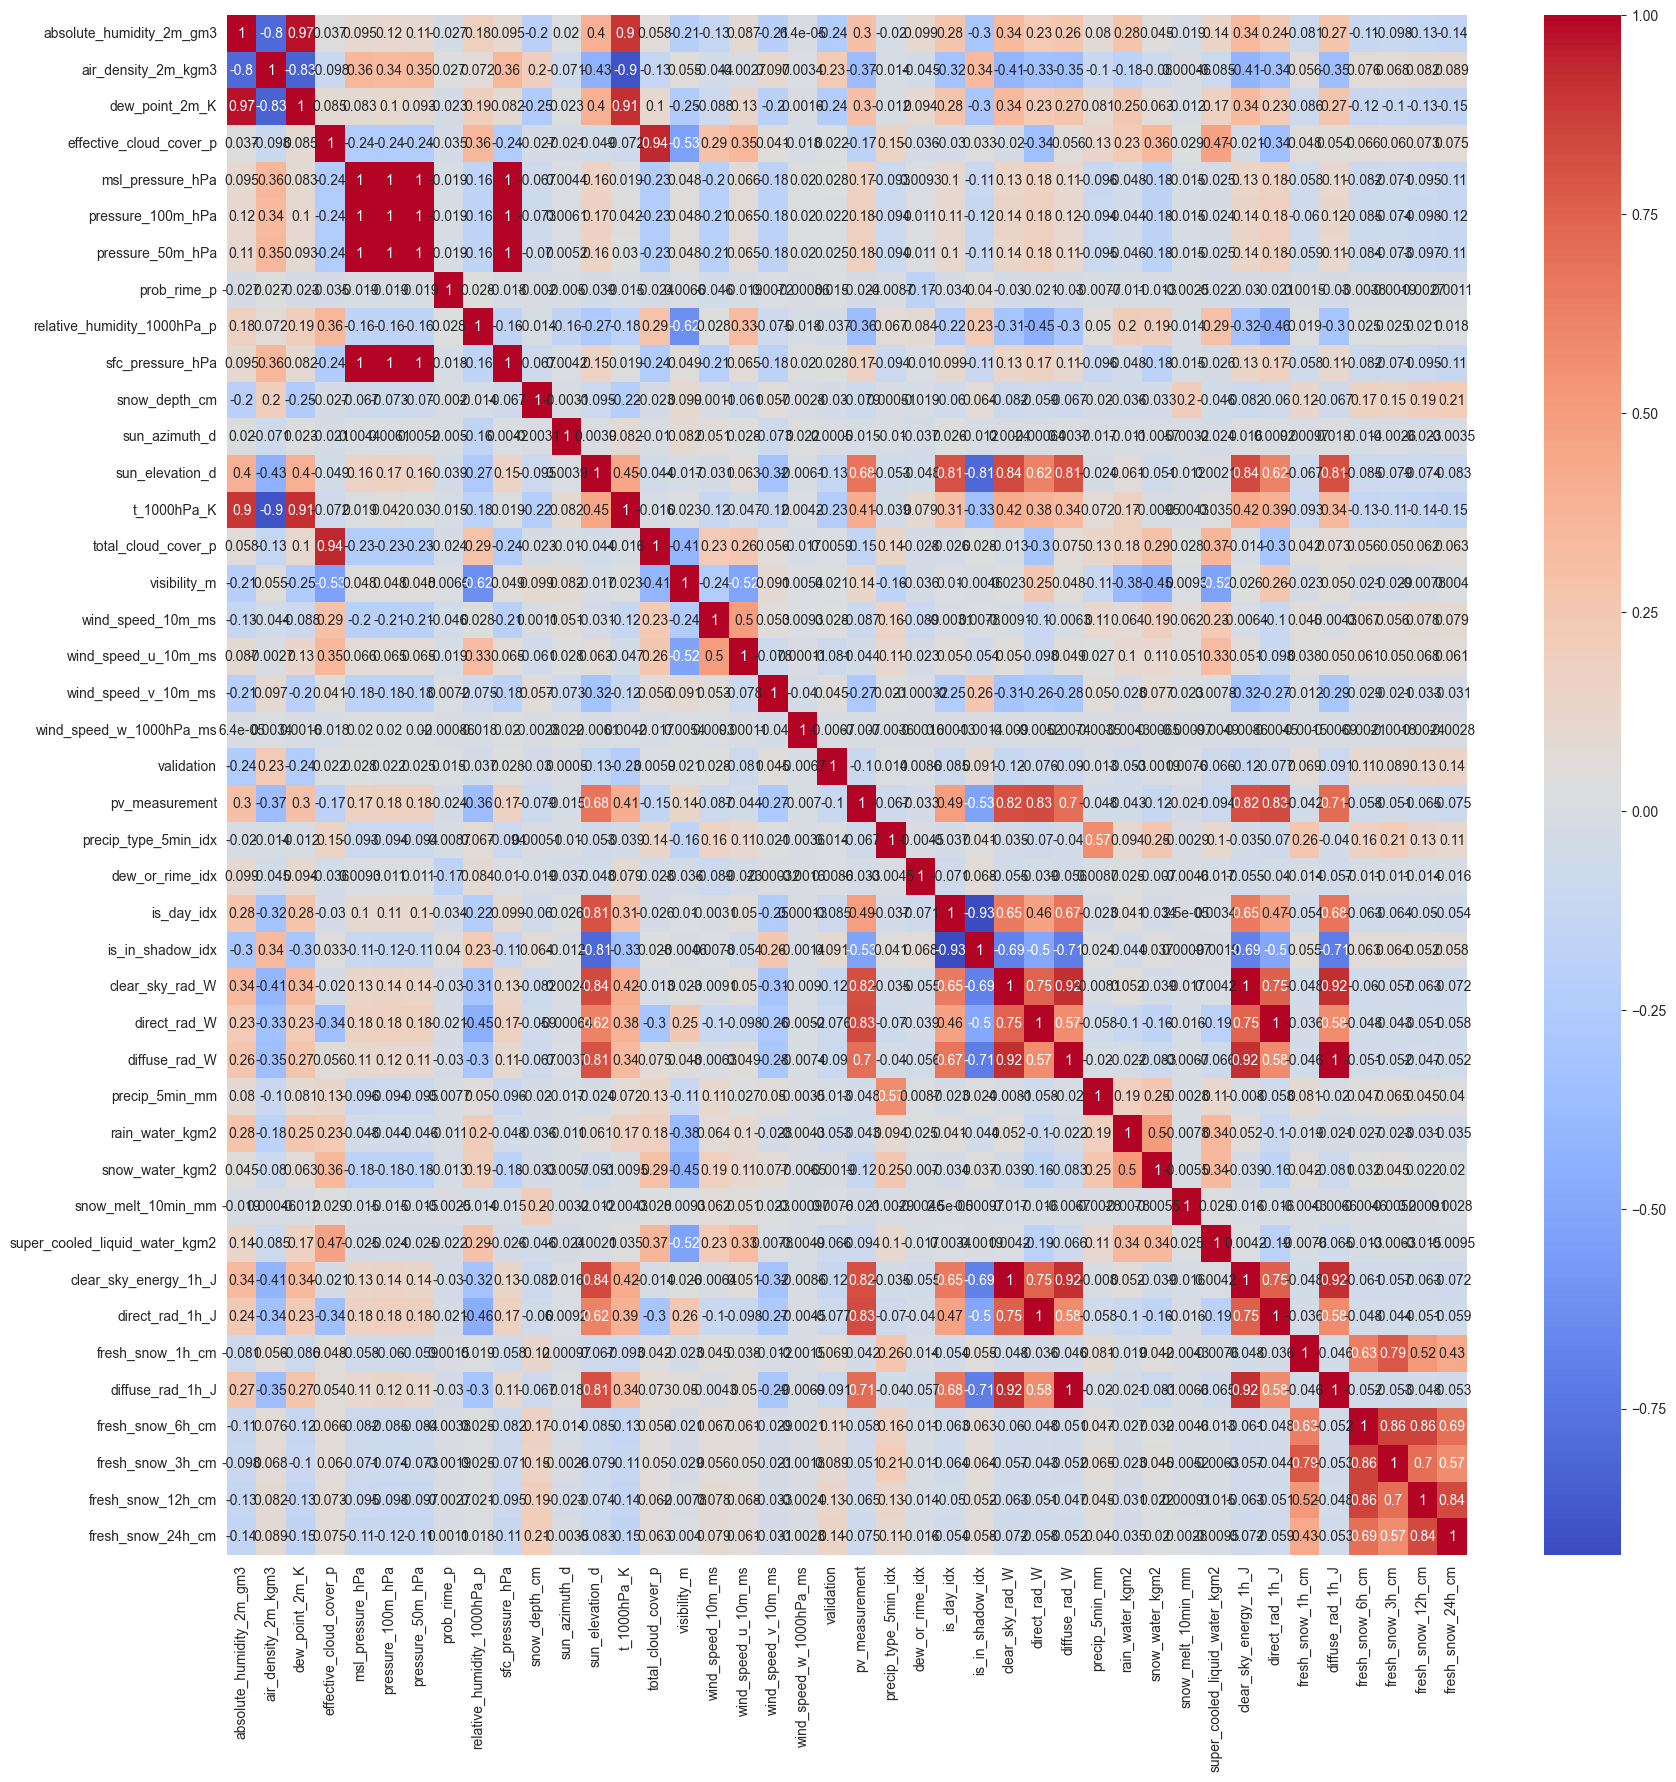

Dataset C:


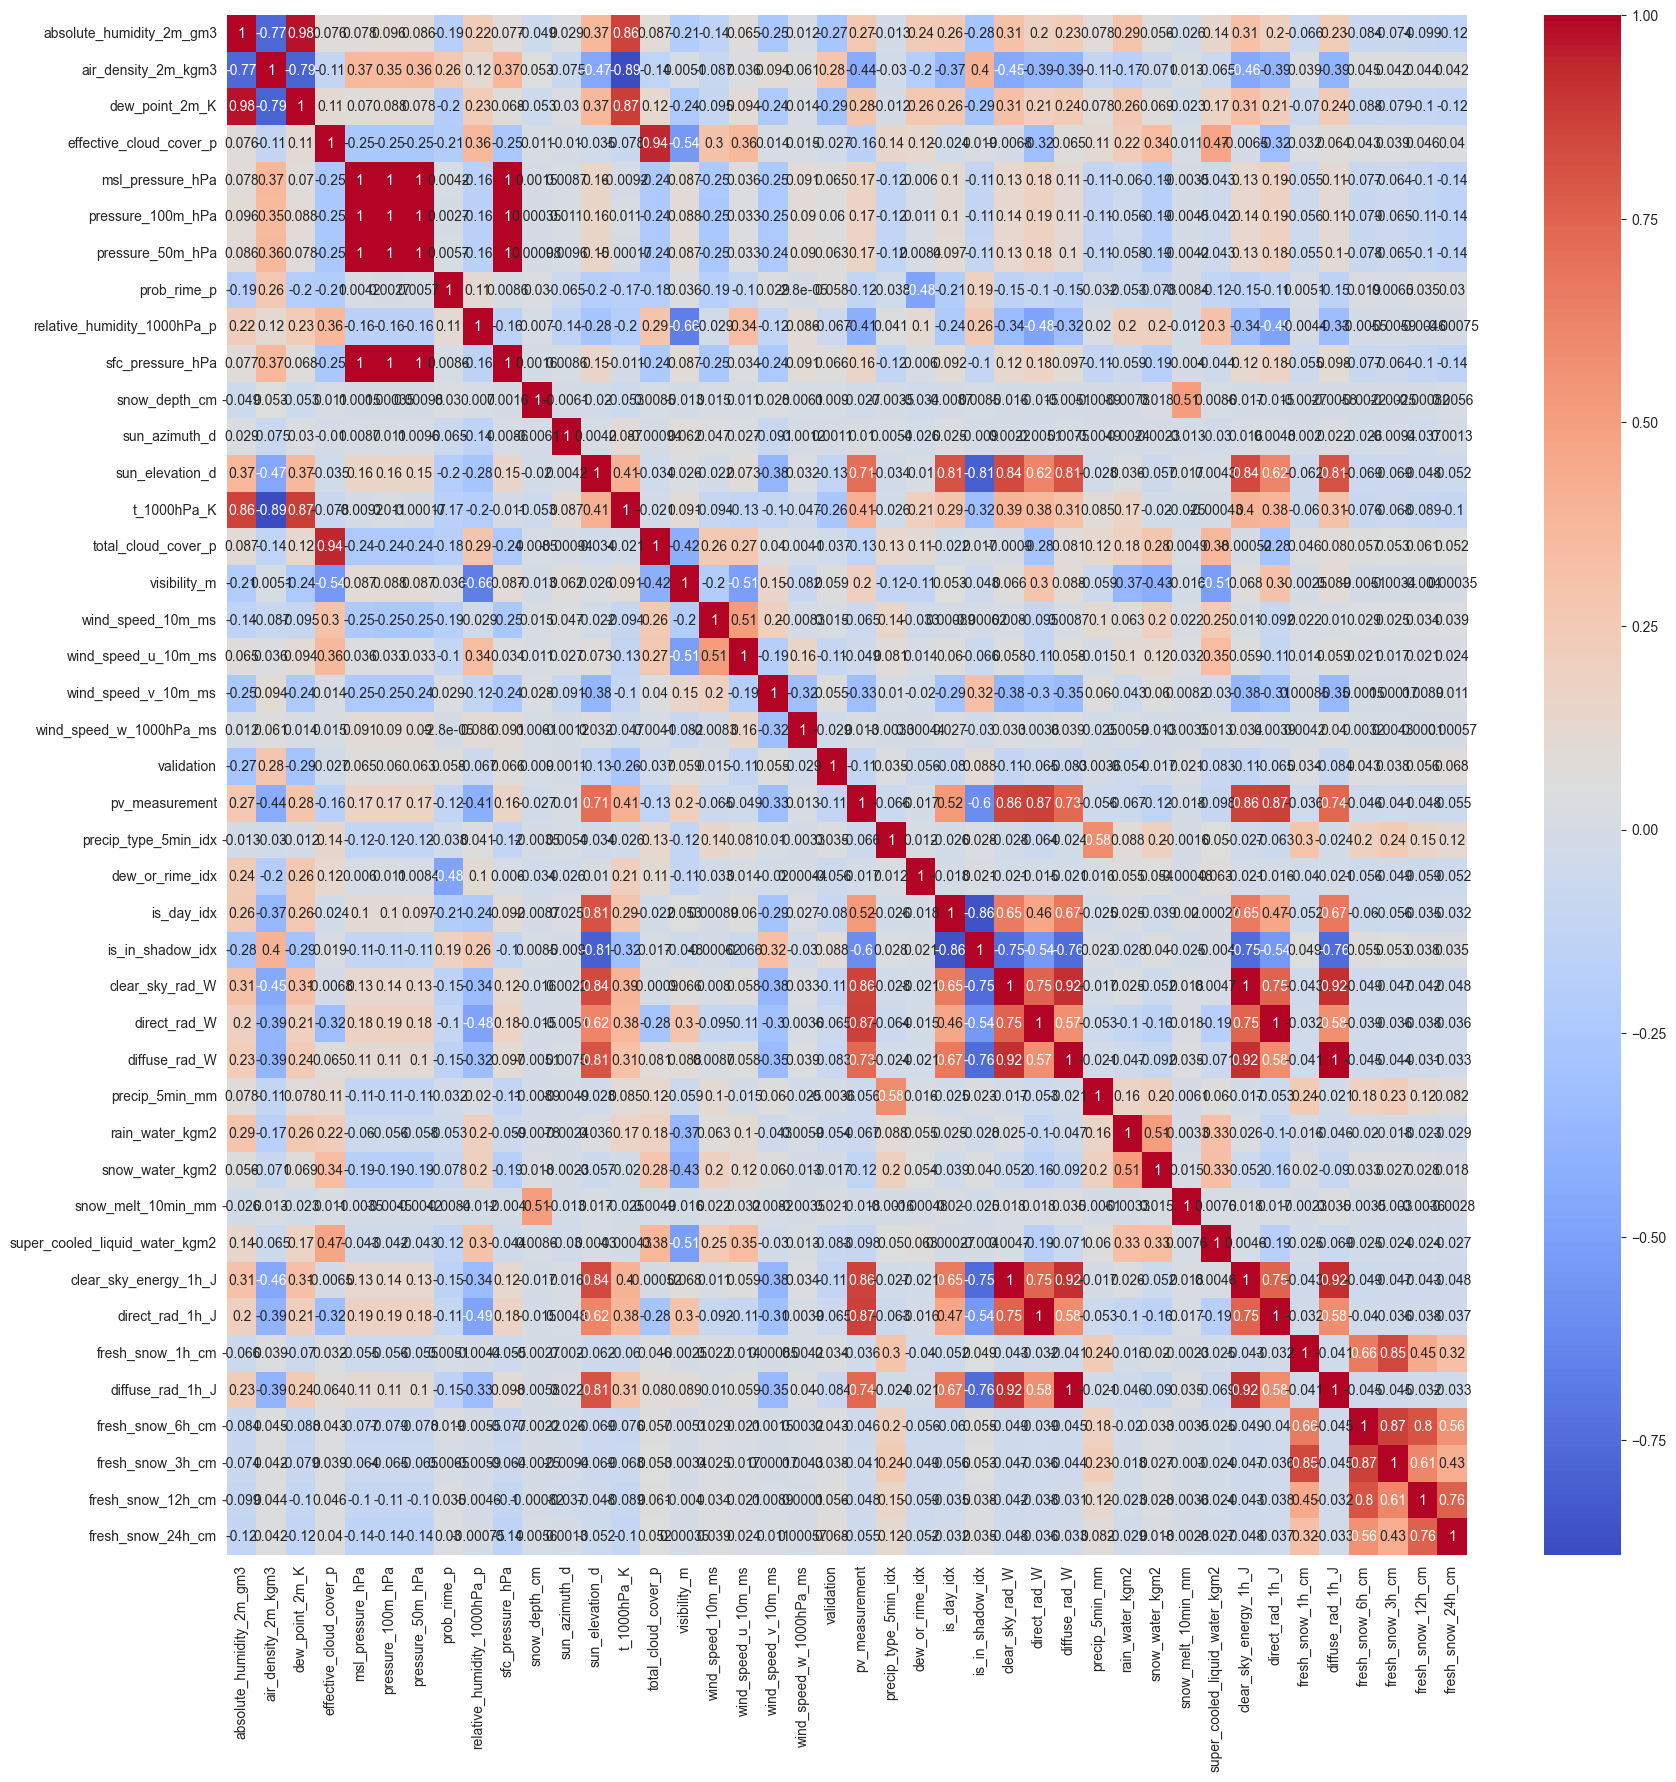

In [85]:
import warnings
warnings.simplefilter("ignore", category=RuntimeWarning)


def show_correlation(df):
    corr = df.corr()
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.show()

print("Dataset A:")
show_correlation(X_train_a)
print("Dataset B:")
show_correlation(X_train_b)
print("Dataset C:")
show_correlation(X_train_c)


After plotting the various correlations, we found several interesting things. One observation was that direct rad, diffuse rad and clear sky energy/rad had a high correlation with pv_measurement. In other words, these features are of great importance for pv measurement. Furthermore, we saw that several of the features correlated to a large extent with each other. Examples of this were features such as 'pressure' and 'fresh_snow'. These were observations we benefited greatly from when we had to carry out feature engineering

## Feature Engineering

### Time feature engineering 
For feature engineering we first looked at the timestamp in our original dataset. When reading up on the different models we found that separate features for the month and hour of day was preferred as to just have the complete timestamp as a single feature. We first introduced these as integer features 1 for month indicating January 2 indicating February etc. and similarly in the range 0-23 for hour of day. This resulted in better predictions. 


In [86]:
def feature_eng(df):
    df['month'] = df.index.month
    df['hour'] = df.index.hour

Following the lecture slides we decided to try sinus and cosinus transformation of the time features to better represent the underlying relation; January comes after December and the beginning of the next day starts right after the end of the previous one. This also yielded better predictions of the PV Measurement. We also tried to add cosinus and sinus transformation of day of month with further improved results. Finally removing the integer features to lower the complexity of the model.

In [87]:
def feature_eng(df):
    

    df.sort_index(inplace=True)
    df['cos_hour'] = np.cos(2 * np.pi * df.index.hour / 24)
    df['cos_month'] = np.cos(2 * np.pi * (df.index.month) / 12)
    df['cos_day_of_month'] = np.cos(2*np.pi * df.index.day / 30 )
    df['sin_hour'] = np.sin(2 * np.pi * df.index.hour / 24)
    df['sin_day_of_month'] = np.sin(2*np.pi * df.index.day / 30 )
    df['sin_month'] = np.sin(2 * np.pi * (df.index.month) / 12)

    return df

### Binary feature indicating difference between estimated and observed
Since we have two datasets with slightly different characteristics one being based on estimated data and one being based on observed data, we felt the need to introduce a feature that informs of this difference through a binary variable, taking the value 1 if the data record comes from the estimated set, and the value 0 if it comes from the observed dataset. This resulted in better prediction power for our model. Since the test data only contains estimated features we believe that also estimated data should be present in the training set to let the model “understand” the differences between estimated and observed data.

In [88]:
## The commented code was done earlier in the script and is only present for demonstrative purpose
#X_train_observed_a['validation'] = False
#X_train_estimated_a['validation'] = True
X_test_A['validation'] = True

#X_train_observed_b['validation'] = False
#X_train_estimated_b['validation'] = True
X_test_B['validation'] = True

#X_train_observed_c['validation'] = False
#X_train_estimated_c['validation'] = True
X_test_C['validation'] = True


### Lag feature
We tried to introduce a lag feature taking the PV measurement of the same day and hour from the previous year as a new feature. This was implemented in two ways first taking the average, max, min and the variance of the measurements of the previous 15 days and the coming 15 days from a year ago at the same timestamp and secondly taking just the exact timestamp from a year ago.

In [89]:
def compute_stats_one_year_before(df, given_datetime):
    target_datetime = given_datetime - pd.DateOffset(years=1)
    
    start_date = target_datetime - pd.DateOffset(days=15)
    end_date = target_datetime + pd.DateOffset(days=15)
    
    desired_datetimes = pd.date_range(start=start_date, end=end_date, freq='D').to_series()
    desired_datetimes = desired_datetimes.apply(lambda x: x.replace(hour=given_datetime.hour, minute=given_datetime.minute, second=given_datetime.second))

    daily_data = [df.loc[dt, 'pv_measurement'] if dt in df.index else np.nan for dt in desired_datetimes]

    mean_value = np.nanmean(daily_data)
    min_value = np.nanmin(daily_data)
    max_value = np.nanmax(daily_data)
    variance = np.nanvar(daily_data)  # Calculate variance

    return mean_value, min_value, max_value, variance

def compute_lag_value(df, given_datetime):

     # Function to search within the hour at specific minutes
    def search_within_hour(df, target_datetime):
        if target_datetime in df.index:
            return df.loc[target_datetime, 'pv_measurement']
        return None

    # Try one year before
    target_datetime = given_datetime - pd.DateOffset(years=1)
    target_datetime = target_datetime.replace(hour=given_datetime.hour, minute=given_datetime.minute, second=given_datetime.second)
    val = search_within_hour(df, target_datetime)
    if val is not None:
        return val

    return None

However this was not successful in lowering the prediction error and was therefore discarded. We think it has too do with needing to drop the entire first year of data as they don’t have values for this feature. In addition dataset B and C contain a lot of missing values and therefore even more records are being dropped.

### Summer Weighting
Since our test dataset is based on the summer months, we have explored using weights to increase the importance of the training data from the summer. This gave better results when testing with AutoGluon, but since AutoGluon as a whole gave us poorer performance than CatBoost and because CatBoost did not improve when using this weighting we decided to discard the approach.

In [90]:
def add_weights(df):
    df['weight'] = 1
    df[df.index.month.isin([4,9,10])]['weight'] = 3
    df[df.index.month.isin([5, 6, 7, 8])]['weight'] = 25
    return df


### Wind direction
We had a thought that the wind direction may not impact PV measurement but rather the absolute value of the wind strength (removing direction). This did not improve our prediction.

In [91]:
def absolute_values_wind(df):
    df['abs_wind_speed_u_10m_ms'] = df['wind_speed_u_10m_ms'].abs()
    df['abs_wind_speed_v_10m_ms'] = df['wind_speed_v_10m_ms'].abs()
    return df

In addition we tried to create a new feature for each direction to better encode wind speed from different orientations rather than using negative values for one of the directions as is default. This did also not result in an improvement and was discarded.

In [92]:
def wind_direction(df):
    df['pos_wind_speed_u_10m_ms'] = df['wind_speed_u_10m_ms'].apply(lambda x: x if x > 0 else 0)
    df['neg_wind_speed_u_10m_ms'] = df['wind_speed_u_10m_ms'].apply(lambda x: x if x < 0 else 0).abs()

    df['pos_wind_speed_v_10m_ms'] = df['wind_speed_v_10m_ms'].apply(lambda x: x if x > 0 else 0)
    df['neg_wind_speed_v_10m_ms'] = df['wind_speed_v_10m_ms'].apply(lambda x: x if x < 0 else 0).abs()

    return df

### Combining diffuse rad and direct rad
To better represent the underlying radiation on the solar panels we added the diffuse rad and direct rad together as an additional feature. This move was supposed to help smoothing out direct rad to better reflect the underlying trend. However, the feature did not impact the prediction performance and was therefore removed.

In [93]:
def add_rad_feature(df):
    df['rad'] = df['diffuse_rad_W'] + df['direct_rad_W']
    return df

### One hot encoding precip type and dew or rime
We have also experimented with one hot encoding the precip type dew or rime without any further success in prediction power. We find it strange that one hot encoding precip type does not improve model quality, since we don’t believe there is a underlying linear relationship between the different types of precip and pv measurement. We did not need to do this on the binary features, such as is_day_idx, is_in_shadow_idx etc.     

In [94]:
def add_one_hot_encoding(df):
    df = pd.get_dummies(df, columns=['precip_type_5min_idx', 'dew_or_rime_idx'])

## Models and training

It is important to both have a fast model for testing and prototypes, but also some models who requires more computational power, but will be more complex and make better predictions. We also used feature importance with all models, but due to faster running speed, we will only demonstrate using LightGBM since it is the fastest model of the ones we tried.

<strong>DISCLAIMER: The sections about model and training in this notebook heavily relies on dataset A to demonstrate what the group has done, without making it three times longer than necessary. All these steps and training were also applied to dataset B and C.</strong>


### Training and reproducibility

The group tried to mimic cross validation when training their final models, by training n different models, using different seeds for the training/validation split. All training/validation data was split in a 90/10 ration. This was done due to needing data to validate the training, but also because we had a lack of data. Other splits that are typical are 80/20 and even 70/30, but these splits are more common with more data available. Mostly seed 42 was used, the "Answer to the Ultimate Question of Life, the Universe, and Everything" (Hitchhiker's Guide to the Galaxy by Douglas Adams)

We also did this because we had varying results in just using a single seed for the split of the dataset used for training the model. To ensure that we didn't pick a "bad seed", we used 5 different, and took the mean of all the predictions

#### Estimated data
The group also got much better results when defining what data is estimated, and what is observed. The group also noticed that it was important to include estimated data in the validation set, because the data the group was going to use to predict was estimated, instead of observed. The group originally only used all the estimated data for the validation, but later found better results mixing the datasets

In [95]:
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor, Pool
import pandas as pd

def get_validation_data(X, seed):
    return train_test_split(X, test_size=0.1, random_state=seed)

def get_validation_data_only_estimated(X):
    X_A = X[X['validation'] == False]
    Val_A = X[X['validation'] == True]

    X_train, X_test= train_test_split(Val_A, test_size=0.5, random_state=42)
    # Remove the filtered rows from the original X and y DataFrames
    X_train = pd.concat([X_A, X_train], axis=0)

    assert not any(X_test.index.isin(X_train.index))
    assert X_test[X_test['validation'] == True]['validation'].all()
    assert X_train[X_train['validation'] == True]['validation'].any()
    return X_train, X_test

def cat_boost_train(cleaned_A_train, cleaned_A_test):
    seeds = [42, 54, 66, 358, 123456]
    preds_A = []
    for i in seeds:
        X_A, Val_A = get_validation_data(cleaned_A_train, i)
        model_a = CatBoostRegressor(loss_function='MAE', verbose=100, n_estimators=1000, random_state=42, early_stopping_rounds=100)

        X_pool = Pool(X_A, label=X_A.pop('pv_measurement'), cat_features=categorical_features)
        X_pool_val = Pool(Val_A, label=Val_A.pop('pv_measurement'), cat_features=categorical_features)

        X_pool_test = Pool(cleaned_A_test, cat_features=categorical_features)

        model_a.fit(X_pool,eval_set=[X_pool_val])



        prediction_A = model_a.predict(X_pool_test)
        preds_A.append(prediction_A)

    prediction_A = np.mean(preds_A, axis=0)

### Categorical features
Some models like catboost is heavily reliant on giving categorical features, and not proess them, like making them one-hot-encoded. After trial and error the group got the best results using these features as categorical features in the catboost model, and these were also used for the other models. In the other models however, these were one-hot-encoded as shown below

In [96]:
## Used for catboost
categorical_features = ['precip_type_5min_idx', 'dew_or_rime_idx', 'is_day_idx', 'is_in_shadow_idx']

## Added one_hot_encoding using pandas
one_hot_encoded_df = pd.get_dummies(X_train_a, columns=categorical_features)

### LightGBM (with feature importance)
LightGBM was used to quickly train models to check the performance. The group also used lightGBM for feature_importance. The parameters were randomly set and found through manual testing

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005480 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6756
[LightGBM] [Info] Number of data points in the train set: 30628, number of used features: 40
[LightGBM] [Info] Start training from score 630.472014
[1]	valid_0's l1: 799.327
[2]	valid_0's l1: 765.379
[3]	valid_0's l1: 733.65
[4]	valid_0's l1: 703.792
[5]	valid_0's l1: 675.894
[6]	valid_0's l1: 649.286
[7]	valid_0's l1: 624.216
[8]	valid_0's l1: 600.788
[9]	valid_0's l1: 578.682
[10]	valid_0's l1: 557.991
[11]	valid_0's l1: 538.502
[12]	valid_0's l1: 520.185
[13]	valid_0's l1: 503.169
[14]	valid_0's l1: 487.145
[15]	valid_0's l1: 472.168
[16]	valid_0's l1: 458.024
[17]	valid_0's l1: 444.919
[18]	valid_0's l1: 432.417
[19]	valid_0's l1: 420.999
[20]	valid_0's l1: 410.151
[21]	valid_0's l1: 400.104
[22]	valid_0's l1: 390.413
[23]	valid_0's l1: 381.45
[24]	valid_0's l1: 372.949
[25]	valid_0's l

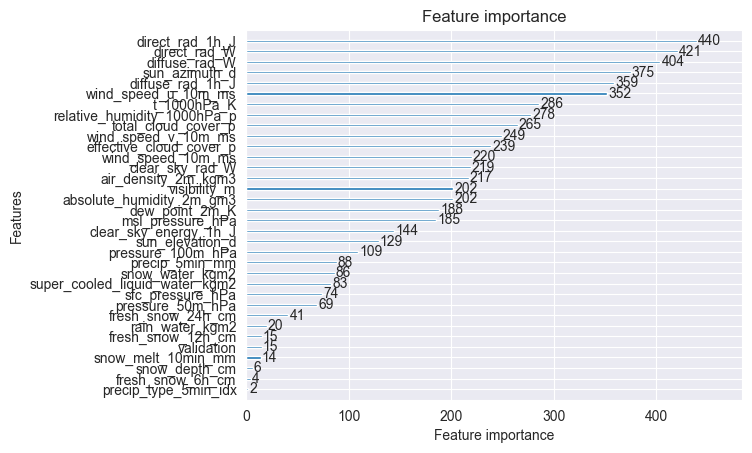

Value                      Feature
40    440              direct_rad_1h_J
39    421                 direct_rad_W
38    404                diffuse_rad_W
37    375                sun_azimuth_d
36    359             diffuse_rad_1h_J
35    352          wind_speed_u_10m_ms
34    286                  t_1000hPa_K
33    278  relative_humidity_1000hPa_p
32    265          total_cloud_cover_p
31    249          wind_speed_v_10m_ms

In [97]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error
import seaborn as sns

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 7,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'max_depth': 12
}
X_A, Val_A = get_validation_data(X_train_a, 42)
num_round = 1000


train_data = lgb.Dataset(X_A, label=X_A.pop("pv_measurement"))
val_y = Val_A.pop("pv_measurement")
val_data = lgb.Dataset(Val_A, label=val_y, reference=train_data)
lgbma = lgb.train(params, train_data, num_round, valid_sets=[val_data])


y_pred = lgbma.predict(Val_A, num_iteration=lgbma.best_iteration)
mae = mean_absolute_error(val_y, y_pred)

lgb.plot_importance(lgbma, max_num_features=35)
plt.show()

# print out the most (top 10) important features in a list
feature_imp = pd.DataFrame(sorted(zip(lgbma.feature_importance(),X_A.columns)), columns=['Value','Feature'])
feature_imp = feature_imp.sort_values(by="Value", ascending=False).head(10)
feature_imp

As one can see, the group added feature importance to the LightGBM to get an overview of the most important features. Features that heavily correlated with pv_measurement in teh correlation analysis are also the most important features for the lightGBM model, which makes sense. The group also used feature importance in the XGBoost and RandomForest ensemble model. This notebook won't run those, due to heavy computational needs.

### Ensemble XGBoost and RandomForest
After using LightGBM for a while, the group thought maybe they needed more robust and strong models. Therefor the group started testing the datasets on an ensemble model of XGBoost and RandomForest. This model was used as the initial testing model, and was a fast way to test the different data cleaning and datasets. The group used weights for this, trying to weight summer and spring more than the winter months, as well as weighting the estimated dataset more than the observed, since we are predicting based on estimated values. The group also experimented with adding specific dates for validation, for optmizing trainig/validation split, but had little luck with this

The xgboost model was also used to show feature importance of the training

In [98]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, VotingRegressor

import xgboost as xgb

def ensemble_xgBoost(features, X, y):
    if isinstance(features, str):
        features = [features]

    specific_dates = ['2022-05-05', '2022-05-10', '2022-05-15', '2022-05-20', '2022-05-25',
                      '2022-06-05', '2022-06-10', '2022-06-15', '2022-06-20', '2022-06-25',
                      '2022-07-01', '2022-07-02', '2022-07-03', '2022-07-04', '2022-07-05',
                      '2022-07-10', '2022-07-15', '2022-07-20', '2022-07-25', '2022-07-28',
                      '2022-07-29', '2022-07-01', '2022-07-02', '2022-07-03', '2022-07-04',
                      '2022-07-05', '2022-07-06', '2022-07-07', '2022-07-08', '2022-07-09']

    if 'weight' not in X.columns:
        X['weight'] = 1
    X_test = pd.DataFrame()
    y_test = pd.DataFrame()
    for date in specific_dates:
        X_date = X[X.index.date == pd.to_datetime(date).date()]
        y_date = y[y.index.date == pd.to_datetime(date).date()]

        # Concatenate the filtered data for each date
        X_test = pd.concat([X_test, X_date])
        y_test = pd.concat([y_test, y_date])


    X_train = X.drop(X_test.index)
    y_train = y.drop(X_test.index)
    weights = X_train.pop("weight")
    X_test.drop(columns=['weight'], inplace=True)
    print(X_train.shape, X_test.shape)

    xgb_model = xgb.XGBRegressor(device = 'cpu', eval_metric = "mae")

    xgb_model.fit(X_train, y_train, eval_set = [(X_train, y_train), (X_test, y_test)],  verbose = True, sample_weight = weights)
    xgb_preds = xgb_model.predict(X_test)

    feature_importances = xgb_model.feature_importances_

    feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=True)

    # Plot feature importances
    plt.figure(figsize=(15, 25))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance in XGBoost Model')
    plt.show()
    rf_model = RandomForestRegressor()

    rf_model.fit(X_train, y_train)


    rf_preds = rf_model.predict(X_test)

    ensemble_model = VotingRegressor(estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
    ],
        weights=weights
    )

    ensemble_model.fit(X_train, y_train)
    ensemble_preds = ensemble_model.predict(X_test)
    #  Evaluate the performance of each model
    mse_xgb = mean_absolute_error(y_test, xgb_preds)
    mse_rf = mean_absolute_error(y_test, rf_preds)
    mse_ensemble = mean_absolute_error(y_test, ensemble_preds)

    print("Mean Absolute Error (XGBoost):", mse_xgb)
    print("Mean Absolute Error (Random Forest):", mse_rf)
    print("Mean Absolute Error (Ensemble):", mse_ensemble)
    return xgb_model

### AutoGluon
To improve our prediction model the autoML framework autogluon was implemented to automatically create good training models.

We tried using different weights on the different rows, like weighting the summer months and validation sets, which can bee seen in the predictor which is a comment. This was combined with CatBoost to get the prediction in short notebook 2.

In [99]:

from autogluon.tabular import TabularPredictor
def auto_gl(train_data, test_data,validation_data, n=5):
    validation_data = validation_data.copy()
    #predictor = TabularPredictor(label='pv_measurement',eval_metric='mae',sample_weight='weight', problem_type='regression', weight_evaluation=True)
    predictor = TabularPredictor(label='pv_measurement',eval_metric='mae', problem_type='regression')

    predictor.fit(train_data, presets=['best_quality'], num_bag_sets=3)

    predictor.evaluate(validation_data, silent=False)
    top_models = predictor.leaderboard(validation_data, silent=False)

    top_models = top_models.head(n)  # Select the top n models
    top_model_predictions = []
    for model in top_models['model']:
        print(model)
        model_predictions = predictor.predict(test_data, model=model)
        model_predictions.to_csv(f"preds/{model}.csv")
        top_model_predictions.append(model_predictions)

    mean_prediction = np.mean(top_model_predictions, axis=0)
    submit_pred = mean_prediction.tolist()
    mae = predictor.predict(validation_data.drop(columns=['pv_measurement']))

    return submit_pred, mae

### H2O
The group also opted to another autoML framework. H2O had been demonstrated in one lectrue, and the group therefore tried using this. It had results similar to the autoGluon framework, which is why the group opted for a new solution.

In [100]:

import h2o
from h2o.automl import H2OAutoML

def h20(path, test_,Val, time = 60*3):

    h2o.init()
    df = h2o.H2OFrame(path)
    train,X_test = df.split_frame(ratios=[.8])
    val = h2o.H2OFrame(Val)

    # Create a test frame with the filtered rows

    print("Shape of the H2OFrame: ", df.shape)
    print("Shape of the test: ", X_test.shape)

    test_to_predict = h2o.H2OFrame(test_)
    target = "pv_measurement"
    aml = H2OAutoML(max_runtime_secs = time, stopping_metric='mae',seed=1, nfolds=5, project_name = "test_lb_frame")
    aml.train(y = target, training_frame = train, leaderboard_frame = X_test, weights_column='weight')

    aml.leaderboard.head()
    best_model = aml.leader
    print(best_model.model_performance(X_test))
    print(f"MAE: {best_model.mae()}")


    ret_val = aml.leader.predict(test_to_predict)
    mae = aml.leader.predict(val)
    mae = mae.as_data_frame()
    mae = mae['predict'].tolist()
    column_df = ret_val.as_data_frame()

    # Convert the Pandas DataFrame to a Python list
    column_list = column_df['predict'].tolist()
    h2o.cluster().shutdown()
    return column_list, mae

### CatBoost with optuna

After mixed success with autogluon and H2O we tried to implement CatBoost and finding the best hyperparameters using the framework optuna. We tried with different methods to get predictions, lik applying Cross-validation and with just a single test/val data set. CatBoost was chosen due to the benefit of automatical categorical feature engineering. We used optuna to tune the following hyperparameters due to reading the documentation of catboost and finding those to be the most important in our opinion:

        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 10),
        "loss_function": "MAE",
        "n_estimators": trial.suggest_int('n_estimators', 5000, 20000),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg",1,10),
        "random_state": 42,
        "early_stopping_rounds":100,

The suggested values of learning_rate, came from being the most common values found online (https://forecastegy.com/posts/catboost-hyperparameter-tuning-guide-with-optuna/)

Depth was set because we wanted deeper trees to ensure getting more complex models

l2_leaf_reg was set between 1, 10, because we wanted some range to the default value of 3.0 (https://catboost.ai/en/docs/references/training-parameters/common#l2_leaf_reg)

The random_state was set as 42 as mentioned earlier

n_estimators was used to ensure the model trained properly. The random state is for reproducablitly and the early stopping to stop overfitting for the train set.

#### Results from optuna
We got some hyperparameter settings out of optuna. Since it was much computational power needed, we got 11 different seeds using the cross validation implementation:

- [I 2023-11-7 14:01:39,965] Trial 0 finished with value: 172.18577828042288 and parameters: {'learning_rate': 0.02943722364107667, 'depth': 6, 'n_estimators': 5426, 'l2_leaf_reg': 9}. Best is trial 0 with value: 172.18577828042288.
- [I 2023-11-7 14:20:22,142] Trial 1 finished with value: 165.61351410766218 and parameters: {'learning_rate': 0.036951510978666426, 'depth': 7, 'n_estimators': 8232, 'l2_leaf_reg': 10}. Best is trial 1 with value: 165.61351410766218.
- [I 2023-11-7 14:36:38,549] Trial 2 finished with value: 166.36556188294603 and parameters: {'learning_rate': 0.07952969445169272, 'depth': 7, 'n_estimators': 7255, 'l2_leaf_reg': 4}. Best is trial 1 with value: 165.61351410766218.
- [I 2023-11-7 15:17:37,099] Trial 3 finished with value: 164.8010103856497 and parameters: {'learning_rate': 0.088968416402354, 'depth': 7, 'n_estimators': 18344, 'l2_leaf_reg': 4}. Best is trial 3 with value: 164.8010103856497.
- [I 2023-11-7 17:40:04,569] Trial 4 finished with value: 160.90311260117184 and parameters: {'learning_rate': 0.07550202727428729, 'depth': 10, 'n_estimators': 17316, 'l2_leaf_reg': 4}. Best is trial 4 with value: 160.90311260117184.
- [I 2023-11-7 18:11:34,369] Trial 5 finished with value: 165.95614877534095 and parameters: {'learning_rate': 0.09672916089120785, 'depth': 8, 'n_estimators': 10958, 'l2_leaf_reg': 2}. Best is trial 4 with value: 160.90311260117184.
- [I 2023-11-7 18:31:02,426] Trial 6 finished with value: 165.6217115328469 and parameters: {'learning_rate': 0.06604731300803197, 'depth': 7, 'n_estimators': 8827, 'l2_leaf_reg': 8}. Best is trial 4 with value: 160.90311260117184.
- [I 2023-11-7 18:59:23,430] Trial 7 finished with value: 166.93647774116658 and parameters: {'learning_rate': 0.029854477813327555, 'depth': 6, 'n_estimators': 19054, 'l2_leaf_reg': 6}. Best is trial 4 with value: 160.90311260117184.
- [I 2023-11-7 21:38:16,910] Trial 8 finished with value: 159.44331316895162 and parameters: {'learning_rate': 0.06702080326361463, 'depth': 10, 'n_estimators': 16265, 'l2_leaf_reg': 3}. Best is trial 8 with value: 159.44331316895162.
- [I 2023-11-7 22:33:08,587] Trial 9 finished with value: 163.08856969605011 and parameters: {'learning_rate': 0.07889144201585677, 'depth': 8, 'n_estimators': 19062, 'l2_leaf_reg': 5}. Best is trial 8 with value: 159.44331316895162.
- [I 2023-11-8 00:27:54,081] Trial 10 finished with value: 156.00927207674218 and parameters: {'learning_rate': 0.01975931319340981, 'depth': 10, 'n_estimators': 13730, 'l2_leaf_reg': 1}. Best is trial 10 with value: 156.00927207674218.



We then tried the different hyperparameters, and found that the ones with lower loss, often resulted in overfitting. Therefore we found trial 7 to be the best:
- [I 2023-11-3 18:59:23,430] Trial 7 finished with value: 166.93647774116658 and parameters: {'learning_rate': 0.029854477813327555, 'depth': 6, 'n_estimators': 19054, 'l2_leaf_reg': 6}. Best is trial 4 with value: 160.90311260117184.

Then we tried different versions of these hyperparameters with small adjustments and landed on the best being:

        "learning_rate": 0.029854477813327555
        "depth": 6, (5 and 7 gave worse, probably because of over/under-fitting)
        "loss_function": "MAE",
        "n_estimators": 19054
        "l2_leaf_reg": 5, (gave better results than the original 6 found from optuna)
        "random_state": 42,
        "early_stopping_rounds":100,

This is also the hyperparameters used in both short notebooks for the CatBoost.


#### Catboost with optuna using Cross Validation

This model uses Cross validation to give a real impression on how good the hyperparameteres are. This does however make the hyperparameter finding time a lot longer

In [101]:

from sklearn.model_selection import KFold
import optuna
from catboost import CatBoostClassifier, CatBoostRegressor, Pool

def cat(trial, train):
    train = train.copy()
    X = train
    y= train.pop('pv_measurement')

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 10),
        "loss_function": "MAE",
        "n_estimators": trial.suggest_int('n_estimators', 5000, 20000),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg",1,10),
        "random_state": 42,
        "early_stopping_rounds":100,

    }


    n_splits = 5
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    cross_val_scores = []

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = CatBoostRegressor(**params)
        train_data = Pool(X_train, label=y_train, cat_features=categorical_features)
        model.fit(train_data, verbose=False)

        test_data = Pool(X_test, label=y_test, cat_features=categorical_features)
        y_pred = model.predict(test_data)

        accuracy = mean_absolute_error(y_test, y_pred)
        cross_val_scores.append(accuracy)

    # Calculate the mean accuracy over all folds
    mean_accuracy = np.mean(cross_val_scores)

    return mean_accuracy

In [102]:

if False:
    cat_with_params = lambda trial: cat(trial, X_A)
    study = optuna.create_study(direction='minimize')
    study.optimize(cat_with_params, n_trials=60)


#### CatBoost with optuna using single train/validation split

This is a faster hyperparameter finder, but more prone to overfitting and might give a wrong impression on how good the model is when only comparing with validation data

In [103]:


from sklearn.model_selection import KFold
import optuna
from catboost import CatBoostClassifier, CatBoostRegressor, Pool


def cat_with_val(trial, val, train):
    # Define the search space for hyperparameters
    train = train.copy()
    val = val.copy()
    X_train = train
    y_train = train.pop('pv_measurement')
    X_val = val
    y_val = val.pop('pv_measurement')

    params = {
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 6, 10),
        "loss_function": "MAE",
        "n_estimators": trial.suggest_int('n_estimators', 5000, 20000),
        "l2_leaf_reg": trial.suggest_int("l2_leaf_reg", 1, 10),
        "random_state": 42,
        "early_stopping_rounds": 100,
        #"task_type": "GPU",

    }

    train_data = Pool(X_train, label=y_train, cat_features=categorical_features)

    model = CatBoostRegressor(**params)  # You can specify CatBoost hyperparameters here
    model.fit(train_data, verbose=False)
    test_data = Pool(X_val, cat_features=categorical_features)
    y_pred = model.predict(test_data)

    # Calculate and store the accuracy for this fold
    mae = mean_absolute_error(y_val, y_pred)

    return mae


In [104]:
if False:
    cat_with_params = lambda trial: cat_with_val(trial, X_A, Val_A)
    study = optuna.create_study(direction='minimize')
    study.optimize(cat_with_params, n_trials=60)


### CatBoost (Short Notebook 1)
The group also tried simply using CatBoost with the hyperparameters found with optuna. This model was the model used in the short notebook 1. As mentioned were different seeds of the training/validation used for more robust models

In [105]:
## Made as func to not run when running notebook
def cat_boost_train(cleaned_A_train, cleaned_A_test):
    seeds = [42, 54, 66, 358, 123456]
    preds_A = []
    for i in seeds:
        X_A, Val_A = get_validation_data(cleaned_A_train, i)
        model_a = CatBoostRegressor(loss_function='MAE', verbose=500, n_estimators=19054, l2_leaf_reg=5, depth=6, random_state=42, early_stopping_rounds=100, learning_rate=0.029854477813327555)

        X_pool = Pool(X_A, label=X_A.pop('pv_measurement'), cat_features=categorical_features)
        X_pool_val = Pool(Val_A, label=Val_A.pop('pv_measurement'), cat_features=categorical_features)

        X_pool_test = Pool(cleaned_A_test, cat_features=categorical_features)

        model_a.fit(X_pool,eval_set=[X_pool_val])



        prediction_A = model_a.predict(X_pool_test)
        preds_A.append(prediction_A)

    prediction_A = np.mean(preds_A, axis=0)


### CatBoost and AutoGluon (Short Notebook 2)
The group had luck with combining the CatBoost model from the Short Notebook 1 which gave good results (142 on kaggle), with the AutoGluon model getting (152 on kaggle). The group experimented with different weights when combining, like (CatBoost/AutoGluon): 50/50, 60/40, 70/30, 80/20 and 90/10 splits. The best splits where when splitting the models 50/50. The group thinks this might make a better model, due to AutoGluon might being good at some aspects of the prediction (sometimes estimating higher values), and the CatBoost being better at others (somtimes estimating lower values)



#### CatBoost

In [106]:
def cat_boost_train(cleaned_A_train, cleaned_A_test):
    seeds = [42, 54, 66, 358, 123456]
    preds_A = []
    for i in seeds:
        X_A, Val_A = get_validation_data(cleaned_A_train, i)
        model_a = CatBoostRegressor(loss_function='MAE', verbose=500, n_estimators=19054, l2_leaf_reg=5, depth=6, random_state=42, early_stopping_rounds=100, learning_rate=0.029854477813327555)

        X_pool = Pool(X_A, label=X_A.pop('pv_measurement'), cat_features=categorical_features)
        X_pool_val = Pool(Val_A, label=Val_A.pop('pv_measurement'), cat_features=categorical_features)

        X_pool_test = Pool(cleaned_A_test, cat_features=categorical_features)

        model_a.fit(X_pool,eval_set=[X_pool_val])



        prediction_A = model_a.predict(X_pool_test)
        preds_A.append(prediction_A)

    prediction_A = np.mean(preds_A, axis=0)


#### AutoGluon

Due to AutoGluon being very demanding in terms of computational power, the group could only use a single seed for the split (42). Because of this, the group chose to combine the top 4 best AutoGluon models, in hopes of making a more robust prediction


In [107]:

def auto_gl(train_data, test_data,validation_data, n=5):
    validation_data = validation_data.copy()
    predictor = TabularPredictor(label='pv_measurement',eval_metric='mae', problem_type='regression')


    predictor.fit(train_data, presets=['best_quality'])
    predictor.evaluate(validation_data, silent=False)
    top_models = predictor.leaderboard(validation_data, silent=False)

    top_models = top_models.head(n)  # Select the top 10 models
    top_model_predictions = []
    for model in top_models['model']:
        model_predictions = predictor.predict(test_data, model=model)
        top_model_predictions.append(model_predictions)

    mean_prediction = np.mean(top_model_predictions, axis=0)
    submit_pred = mean_prediction.tolist()
    mae = predictor.predict(validation_data.drop(columns=['pv_measurement']))


    return submit_pred


In [108]:
def auto_gl_train(cleaned_A_train,cleaned_A_test, seeds):
    X_A, Val_A = get_validation_data(cleaned_A_train.copy(), seeds[0])
    cleaned_A_test_copy = cleaned_A_test.copy()


    prediction_A_auto = auto_gl(X_A, cleaned_A_test_copy, Val_A, n=4)


#### Combining the two predictions
We got the best result when combining the predictions from the different models using this split (70/30) (CatBoost, AutoGluon) * 0.4 + 0.6 CatBoost. This was found through trial and error
<strong>DISCLAIMER: This just for demonstrating how it was done. Look in Short Notebook 2 for entire code </strong>


In [109]:
def combine(df_cat, df_autogluon):
    df_cat = pd.DataFrame()
    df_autogluon = pd.DataFrame()
    df = pd.DataFrame()
    df['id'] = df_cat['id']
    df['prediction'] = (df_cat['prediction'] * 0.7 + df_autogluon['prediction']*0.3) * 0.4 + df_cat['prediction'] * 0.6



## Model Interpretation

As mentioned we have used feature_importance, but we also used PDP for model interpretation


### PDP
"Partial dependence plot (PDP) is used to show the marginal effect features have on the predicted outcome of a ML model. This plot can show the whether there is a relationship between the target and the features are linear, monotonic, or more complex" (https://christophm.github.io/interpretable-ml-book/pdp.html). We used the lightgbm model from sklearn for fast plotting, and used the best features found from the earlier lightgbm run in the df feature_imp

Some features were removed like categorical features due to having problems displaying them in PDP.


In [110]:
# Create PDPs
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error

params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 7,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'lambda_l1': 0.1,
    'lambda_l2': 0.1,
    'max_depth': 12
}
X_A, Val_A = get_validation_data(X_train_a, 42)
# Plot partial dependence for Feature1 and Feature2 using scikit-learn's plot_partial_dependence
features = ['absolute_humidity_2m_gm3', 'air_density_2m_kgm3',
            'clear_sky_energy_1h_J', 'clear_sky_rad_W', 'dew_or_rime_idx',
            'dew_point_2m_K', 'diffuse_rad_W', 'diffuse_rad_1h_J', 'direct_rad_W',
            'direct_rad_1h_J', 'effective_cloud_cover_p', 'msl_pressure_hPa', 'precip_5min_mm',
            'precip_type_5min_idx', 'pressure_100m_hPa', 'pressure_50m_hPa',
             'rain_water_kgm2', 'sfc_pressure_hPa', 'snow_melt_10min_mm', 'snow_water_kgm2',
            'sun_azimuth_d', 'sun_elevation_d', 'super_cooled_liquid_water_kgm2',
            't_1000hPa_K', 'total_cloud_cover_p', 'visibility_m',
            'wind_speed_10m_ms', 'wind_speed_u_10m_ms', 'wind_speed_v_10m_ms',
            'wind_speed_w_1000hPa_ms', 'pv_measurement']

X_A = X_A[features]

pdp_lgbma = lgb.LGBMRegressor(**params).fit(X_A, X_A.pop("pv_measurement"))



[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] lambda_l1 is set=0.1, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1
[LightGBM] [Warning] lambda_l2 is set=0.1, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1


C:\Users\vizlab_stud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
C:\Users\vizlab_stud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
C:\Users\vizlab_stud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim([min_val, max_val])
C:\Users\vizlab_stud\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\inspection\_plot\partial_dependence.py:972: UserWarning: Attempting to

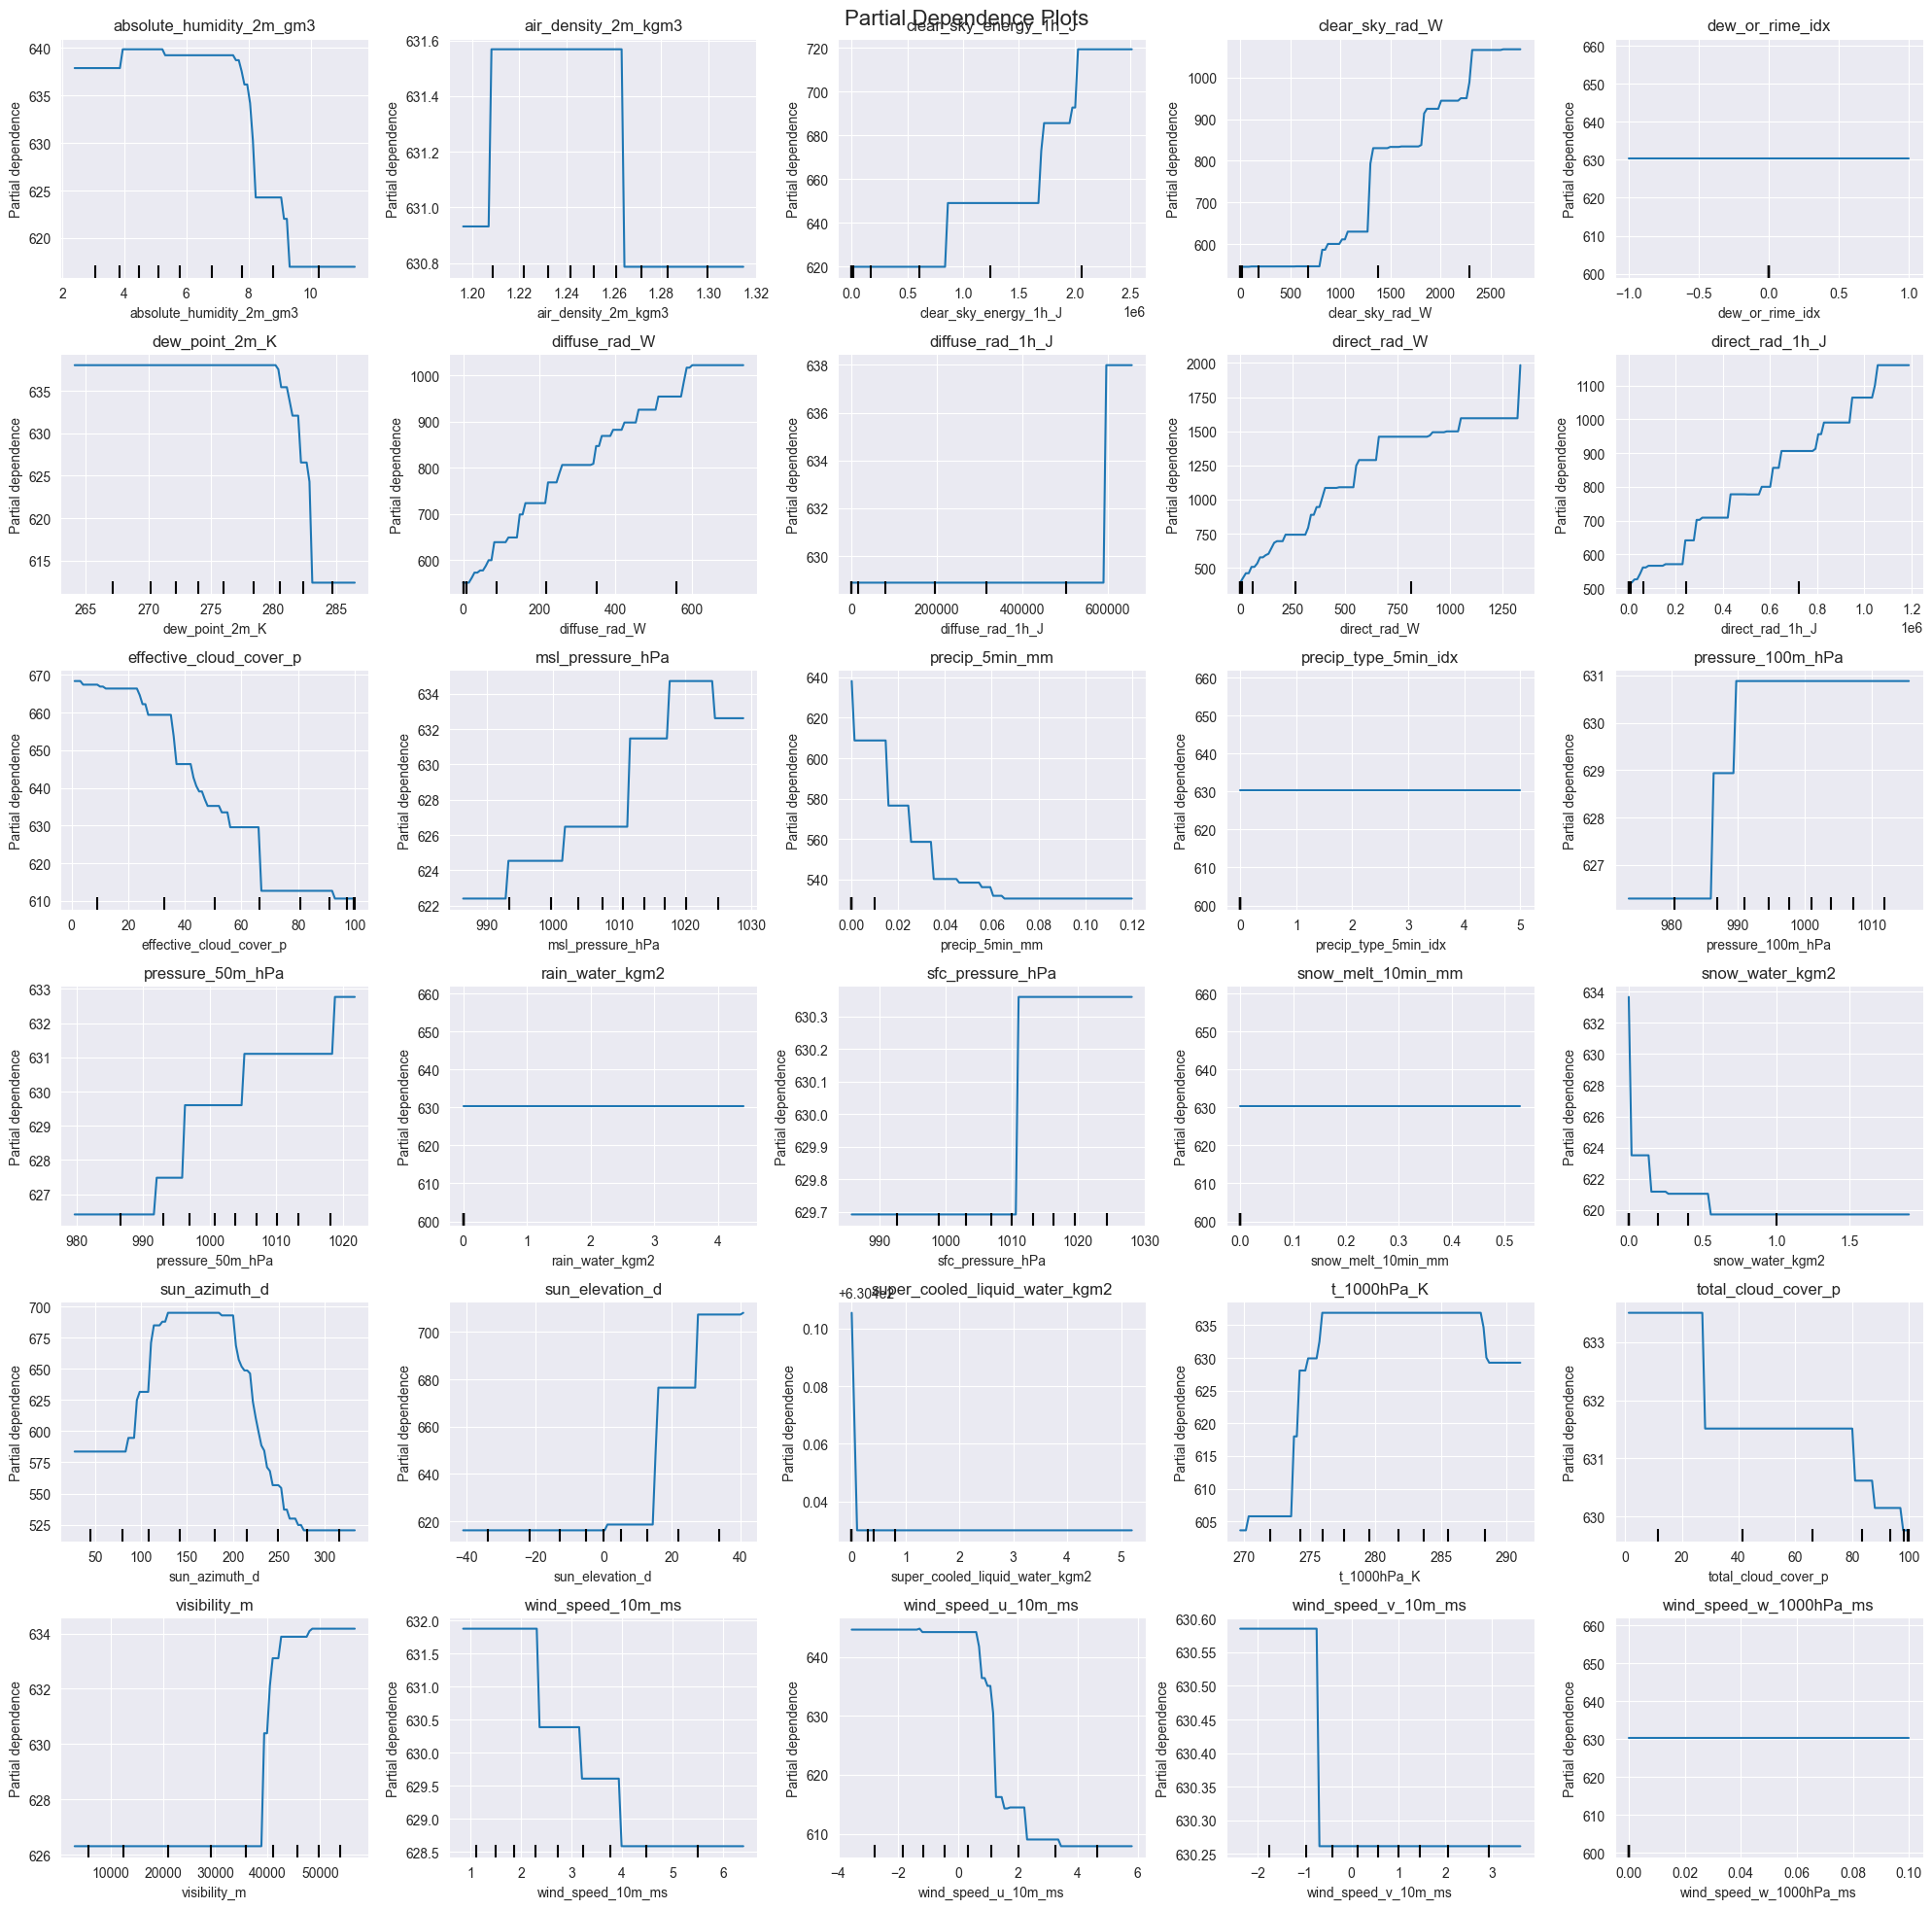

In [111]:


fig, axes = plt.subplots(6, 5, figsize=(20, 20))


for i, ax in enumerate(axes.flatten()):
    PartialDependenceDisplay.from_estimator(pdp_lgbma, X_A, features=[i], grid_resolution=100, ax=ax)
    ax.set_title(features[i])

plt.suptitle('Partial Dependence Plots', fontsize=16)
plt.tight_layout()
plt.show()

As one can see, this gives insight in how each features variability affects the prediction of the model. Features like sun_azimuth, diffuse and direct rad has a lot of impact of the change in the prediction of the model, while super_cooled_liquid_water_kgm2, rain_water, wind_speed_v_10ms, wind_speed_w_1000hPa_ms had less impact of the prediction. This led to us needing to investigate these features more, and maybe remove them if they aren't useful. But If one goes back to the feature importance plot, one might see that super_cooled_liquid_water is somewhat important, which is why these features aren't removed, because things like a hypothesis of importance, and seeing things like the feature importance saying otherwise than the PDP. Some interesting findings are also that visibility and wind speed has impact on the prediction of the model.